## Shopify Summer 2022 Data Science Intern Challenge 
### Submission of Sharad Shashank
#### Georgia Institute of Technology
##### shashank.sharad@gatech.edu

<img src="Distr_plot.gif" align="center">


### Problem Statement

On Shopify, we have exactly 100 sneaker shops, and each of these shops sells only one model of shoe. We want to do some analysis of the average order value (AOV). When we look at orders data over a 30 day window, we naively calculate an AOV of $3145.13. Given that we know these shops are selling sneakers, a relatively affordable item, something seems wrong with our analysis. 

- Think about what could be going wrong with our calculation. Think about a better way to evaluate this data. 
- What metric would you report for this dataset?
- What is its value?

In [62]:
#Import Packages
import numpy as np
import pandas as pd

import scipy
from scipy.stats import mode
from scipy.stats import normaltest
from scipy.stats import trim_mean

import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.gofplots import qqplot

In [31]:
#read Data
df = pd.read_csv('data.csv')
df.head()

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
0,1,53,746,224,2,cash,2017-03-13 12:36:56
1,2,92,925,90,1,cash,2017-03-03 17:38:52
2,3,44,861,144,1,cash,2017-03-14 4:23:56
3,4,18,935,156,1,credit_card,2017-03-26 12:43:37
4,5,18,883,156,1,credit_card,2017-03-01 4:35:11


In [32]:
df.describe()

,order_id,shop_id,user_id,order_amount,total_items
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000
mean,2500.500000,50.078800,849.092400,3145.128000,8.78720
std,1443.520003,29.006118,87.798982,41282.539349,116.32032
min,1.000000,1.000000,607.000000,90.000000,1.00000
25%,1250.750000,24.000000,775.000000,163.000000,1.00000
50%,2500.500000,50.000000,849.000000,284.000000,2.00000
75%,3750.250000,75.000000,925.000000,390.000000,3.00000
max,5000.000000,100.000000,999.000000,704000.000000,2000.00000


From the above table we see that the max value for order_amount is 704000, which is way higher than the 75% quantile value, indicating that **we may have potential outliers on the higher end.**

## Data Exploration

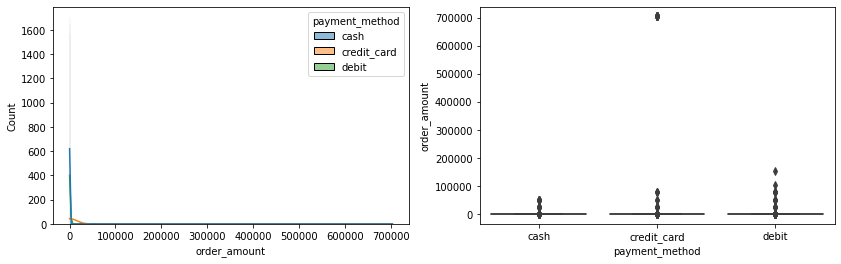

In [42]:
f,ax = plt.subplots(1,2, figsize = (14, 4))
hplot = sns.histplot(x = "order_amount", data=df, binwidth=1000, kde = True, hue = "payment_method", ax = ax[0])
bplot = sns.boxplot(x="payment_method", y="order_amount", data=df)

As we can see from the above histogram and boxplot, there are several potential outliers in the order_amount data. Histogram shows extremely skewed distribution for all the payment methods. The boxplot shows values quite high than the interquartile range, especially for credit_card payment method.

Hence, the average order value (AOV) calculated naively will overestimate its value. Thus we are getting a high AOV of $3145.13. We need a method to calculate the mean or the central tendencies which can handle outliers.

## Central Tendency for Data With Outliers
I devise the following workflow to get a robust estimate of central tendency of a 1D data:

<img src="Flowchart.png" width = 700 align="center">

## Normality Test
We asses the normality of the data using histogram of order_amount and log(order_amount), QQ-plot of order_amount and log(order_amount). 

Text(0.5, 1.0, 'QQ-Plot of log(Order Amount)')

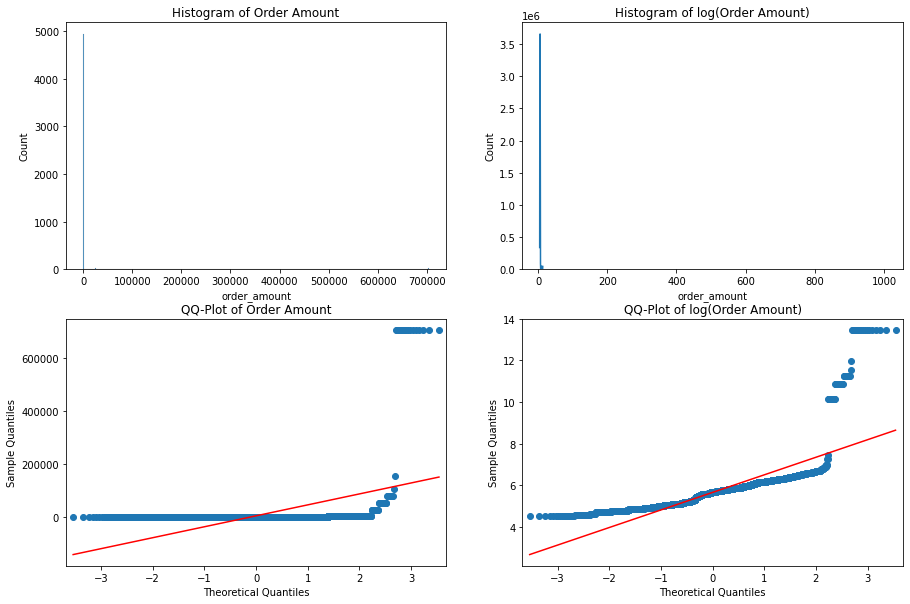

In [102]:
f,ax = plt.subplots(2,2, figsize = (15, 10))
hplot1 = sns.histplot(x = df["order_amount"], binwidth=1000, ax = ax[0,0])
hplot2 = sns.histplot(x = np.log(df["order_amount"]), binwidth=1000, kde = True, ax = ax[0,1])

qqplot1 = qqplot(df["order_amount"], line='s', ax = ax[1,0]).gca().lines
qqplot2 = qqplot(np.log(df["order_amount"]), line='s', ax = ax[1,1]).gca().lines

ax[0,0].set_title("Histogram of Order Amount")
ax[0,1].set_title("Histogram of log(Order Amount)")
ax[1,0].set_title("QQ-Plot of Order Amount")
ax[1,1].set_title("QQ-Plot of log(Order Amount)")

From above plots, we can clearly see that there is a significant deviation from Normality. Apart form this graphical analysis, we also perform a statistical test called **D’Agostino and Pearson’s test** which combines skew and kurtosis to produce an omnibus test of normality. This test tests the null hypothesis that a sample comes from a normal distribution.

In [103]:
stat, p = normaltest(df["order_amount"])

alpha = 0.05
if p > alpha:
    msg = 'Sample looks Gaussian (fail to reject H0)'
else:
    msg = 'Sample does not look Gaussian (reject H0)'

result_mat = [
    ['Length of the sample data', 'Test Statistic', 'p-value', 'Comments'],
    [len(df["order_amount"]), stat, p, msg]
]

normt_table = ff.create_table(result_mat)
normt_table['data'][0].colorscale=[[0, '#2a3f5f'],[1, '#ffffff']]
normt_table['layout']['height']=200
normt_table['layout']['margin']['t']=50
normt_table['layout']['margin']['b']=50
normt_table

From the above tests, we **conclude that the data is not Normal.** Hence we will have to either use the median or compute truncated mean by disregarding outliers.

## Solution: Truncated Mean
A truncated mean or trimmed mean is a statistical measure of central tendency, much like the mean and median. We calculate the mean after disregarding certain parts of the data's probability distribution from high/low ends. 
We disregard a given percentage of samples from either ends.

## Interactive Visualization of Impact of Outliers on Central Tendencies

The mean is more sensitive to the existence of outliers than the median or mode. We visualize the same for the available data.

### Please use the slider to visualize the changes in mean, median and modes as we allow point outliers in our data. This can be used to identify a potential threshold value of Order Amount to filter out outliers and calculate the mean using Truncated Mean method.

In [105]:
fig = go.Figure()

# Add traces, one for each slider step
thshld_vals = [100, 200, 300, 400, 500, 600, 700, 1000, 2000, 5000, 10000, 50000, 100000, 150000, 200000, 500000, 800000]
means, medians, modes = [], [], []

fig = make_subplots(rows=1, cols=2)

for max_val in thshld_vals:
    df_fil = df[df["order_amount"]<=max_val]
    fig.add_trace(
        go.Histogram(x=list(df_fil["order_amount"]), name="Histogram (Order Amount)"),
        row=1, col=1, 
    )
    fig.add_trace(
        go.Box(y=list(df_fil["order_amount"]), name="Boxplot (Order Amount)"),
        row=1, col=2, 
    )

    means.append(np.round(np.mean(df_fil["order_amount"]), 2))
    medians.append(np.round(np.median(df_fil["order_amount"]), 2))
    modes.append(mode(df_fil["order_amount"])[0][0])


fig.data[2].visible = True
fig.data[3].visible = True


# Create and add slider
steps = []
for i in range(len(thshld_vals)):
    step = dict(
        method="update",
        args=[{"visible": [False] * len(fig.data)},
              {"title": "Distribution of Order Amount clipped above: "+str(thshld_vals[i])+" | Mean: "+str(means[i])+" | Median: "+str(medians[i])+" | Mode: "+str(modes[i])}],
        label = thshld_vals[i]
    )
    step["args"][0]["visible"][2*i] = True 
    step["args"][0]["visible"][2*i+1] = True
    steps.append(step)

sliders = [dict(
    active=0,
    currentvalue={"prefix": "Upper Limit on Order Amount: "},
    pad={"t": 50},
    steps=steps
)]

fig.update_layout(
    sliders=sliders,
)

fig.show()

## One Robust Mean Calculation Function for All!

From the above plot, the user can identify the minimum value of Order Amount that seems to be an outlier. This value can be optionally provided in the following **calculate_truncated_mean** function to get a mean that is unaffected due to outliers. The function performs two tasks:

<mark>1. If the user specifies a upper limit on the Order amount value to be used as outlier threshold (depending upon business reasons), it returns the corresponding trimmed mean. This is done by calculating mean after removing a percentage of samples from both the high and low ends of the sorted version of data. The percentage gets automatically calculated based on the value of the user provided threshold </mark>

<mark>
2. If the user doesn't specify the outlier threshold, it identifies samples as Outliers which are more than 1.5*IQR of 75th percentile (Q3) and less than 1.5*IQR of 25th percentile (Q1) </mark>

In [106]:
def calculate_truncated_mean(data, upper_val=None):
    data_ = sorted(data)
    if upper_val:
        arr = np.asarray(data_)
        i = (np.abs(arr - upper_val)).argmin()
        ind = data_.index(arr[i])
        cutoff_per = len(data_[ind:])/len(data_)
        return int(trim_mean(data_, cutoff_per))
    else:
        data_ = pd.DataFrame(data)
        Q1 = data_.quantile(q=.25)
        Q3 = data_.quantile(q=.75)
        IQR = data_.apply(scipy.stats.iqr)
        data_clean = data_[~((data_ < (Q1-1.5*IQR)) | (data_ > (Q3+1.5*IQR))).any(axis=1)]
        return int(np.mean(data_clean).values[0])

## Result

In [107]:
#Mean using user defined outlier threshold
print("Mean Order amount using user defined threshold: {}".format(calculate_truncated_mean(df["order_amount"], 730)))

#Mean without user defined outlier threshold
print("Mean Order Amount without using user defined threshold: {}".format(calculate_truncated_mean(df["order_amount"])))

Mean Order amount using user defined threshold: 299
Mean Order Amount without using user defined threshold: 293
